This notebook is part of the PyImageJ [Tutorial Series](./notebooks.rst), and assumes familiarity with the ImageJ API. Dedicated tutorials for ImageJ can be found [here](https://imagej.net/tutorials/).

# 8 Discover ImageJ commands with the Recorder

The original ImageJ contains many useful commands that can be hard to use in PyImageJ without some prior knowledge on the their parameters. This notebook demonstrates how to use ImageJ's `Recorder` feature to record ImageJ commands in a supported language (`IJ Macro`, `BeanScript`, `Java` and `JavaScript`). 

## 8.1 Example 1: Apply "Find Maxima..." command to an image

In this example we will use "Find Maxima" on a test image. Once the image is loaded, open the `Recorder` (see image below) and begin running commands to capture the code lines.

![Open macro recorder](doc-images/imagej_ui_macro_recorder.png)

Now that the `Recorder` window is open and listening for commands, set the recorder language to either `Java` or `JavaScript` before running the "Find Maxima..." command. Next run the "Find Maxima..." command (**Process** > **Find Maxima...**) to capture the code lines.

![Macro recorder](doc-images/macro_recorder_find_maxima.png)

Running "Find Maxima..." (set to `prominence=1000` and `Point Selection`) on `test_still.tif` results in 21 detections which are then overlayed over the input image.:

![Result](doc-images/test_still_find_maxima.png)

Now that we have the `Java` code for the "Find Maxima..." command we can replicate this workflow in PyImageJ. The "Find Maxima..." command will overlay detections ontop of a displayed input image, therefore we will need to initialize ImageJ in `interactive` mode. Please note that MacOS users will have to change the mode to `gui` due to architecture limitations. For more information please visit the [initialization](Initialization.md) documentation.

In [1]:
import imagej

# initialize ImageJ2
ij = imagej.init(mode='headless')
print(f"ImageJ2 version: {ij.getVersion()}")

ImageJ2 version: 2.13.1/1.54d


Because the "Find Maxima..." and other original ImageJ commands work with the `ImagePlus` object type (instead of the newer ImageJ2/ImgLib2 `Dataset` and `ImgPlus` object types) we need to first convert the `Dataset` returned from `ij.io().open()` to an `ImagePlus`.

Operating in headless mode - the original ImageJ will have limited functionality.


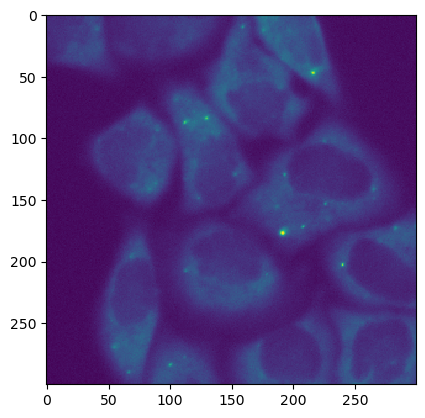

In [2]:
# open test image and convert from Dataset to ImagePlus
dataset = ij.io().open('sample-data/test_still.tif')
imp = ij.py.to_imageplus(dataset)

# show the image
ij.py.show(imp)

Next, show the image with ImageJ and run `Find Maxima...` using the same `Java` syntax generated from the recorder.

In [3]:
# show image and then find maxima
imp.getProcessor().resetMinAndMax()
ij.ui().show(imp)
ij.IJ.run(imp, "Find Maxima...", "prominence=1000 output=[Point Selection]")

[java.lang.Enum.toString] [INFO] null = img["test_still.tif" (-2), 16-bit, 300x300x1x1x1]
Operating in headless mode - the IJ class will not be fully functional.


[INFO] null = img["test_still.tif" (-2), 16-bit, 300x300x1x1x1]


## 8.2 Example 2: Extract a slice and run "Analyze Particles..."

Let's try a more complicated example next. This Java code was generated with the ImageJ Recorder while analyzing some data.

```java
imp = IJ.openImage("sample-data/test_timeseries.tif");
imp2 = new Duplicator().run(imp, 3, 3, 1, 1, 14, 14);
IJ.run(imp, "Enhance Contrast", "saturated=0.35");
IJ.setAutoThreshold(imp, "Moments dark");
IJ.run(imp, "Analyze Particles...", "  show=Overlay display clear");
```

The Java code takes the `test_timeseries.tif` sample data (4D: [X, Y, Channel, Time]) and performs the following operations:

1. Open the test data.
2. Duplicate channel 3, frame 14 (extracts a single still from the timeseries).
3. Enhance the contrast of the image.
4. Threshold with "Moments dark".
5. Analyze particles and display results via overlay.

**Results:**

![Analyze Particles](doc-images/test_still_analyze_particles.png)

Note that in this example we will use the orginal ImageJ's image opener (`IJ.openImage()`) instead of ImageJ2's (`ij.io().open()`). The original ImageJ's opener is more limited than ImageJ2's however it will return an `ImagePlus` image object instead of a `Dataset`, thus no conversion step is needed like in the previous example.

Just like in the _Example 1_ the `Java` code generated from the Recorder can be typically used with little to no modification for language syntax (take note of the different syntax needed to use the `Duplicator`):

In [4]:
from scyjava import jimport

# get ImageJ's duplicator
Duplicator = jimport('ij.plugin.Duplicator')

# run ImageJ commands
imp_timeseries = ij.IJ.openImage("sample-data/test_timeseries.tif")
imp_extract = Duplicator().run(imp_timeseries, 3, 3, 1, 1, 14, 14) # visit the Javadoc for more info https://imagej.nih.gov/ij/developer/api/ij/ij/plugin/Duplicator.html
ij.IJ.run(imp_extract, "Enhance Contrast", "saturated=0.35")
ij.ui().show(imp_extract)
ij.IJ.setAutoThreshold(imp_extract, "Moments dark")
ij.IJ.run(imp_extract, "Analyze Particles...", " show=Overlay display clear")

[INFO] null = img["DUP_test_timeseries.tif" (-5), 16-bit, 250x250x1x1x1]
 	Area	Mean	Circ.	Feret	IntDen	RawIntDen	FeretX	FeretY	FeretAngle	MinFeret	AR	Round	Solidity
1	0.211	1293	1.000	0.727	273.146	2586	149	42	116.565	0.325	2.000	0.500	1.000
2	0.739	1216.143	0.800	1.340	899.186	8513	88	44	104.036	0.975	1.387	0.721	0.737
3	0.106	1333.000	1.000	0.460	140.798	1333	79	51	135.000	0.325	1.000	1.000	1.000
4	0.528	1193.400	1.000	1.172	630.264	5967	96	53	146.310	0.650	1.553	0.644	0.909
5	0.317	1241.667	1.000	0.919	393.453	3725	133	55	45.000	0.650	1.464	0.683	0.857
6	180.091	1513.540	0.077	32.384	272574.304	2580585	112	68	148.543	13.747	2.528	0.396	0.542
7	0.106	1104.000	1.000	0.460	116.610	1104	181	53	135.000	0.325	1.000	1.000	1.000
8	3.803	1478.194	0.600	3.250	5620.835	53215	89	54	126.870	2.103	1.913	0.523	0.742
9	0.211	1268.000	1.000	0.727	267.865	2536	154	54	116.565	0.325	2.000	0.500	1.000
10	0.211	1171.000	1.000	0.727	247.374	2342	79	55	116.565	0.325	2.000	0.500	1.000
11	0.106	1257.000	1.0

[java.lang.Enum.toString] [INFO] null = img["DUP_test_timeseries.tif" (-5), 16-bit, 250x250x1x1x1]
[java.lang.Enum.toString]  	Area	Mean	Circ.	Feret	IntDen	RawIntDen	FeretX	FeretY	FeretAngle	MinFeret	AR	Round	Solidity[java.lang.Enum.toString] 
[java.lang.Enum.toString] 1	0.211	1293	1.000	0.727	273.146	2586	149	42	116.565	0.325	2.000	0.500	1.000[java.lang.Enum.toString] 
[java.lang.Enum.toString] 2	0.739	1216.143	0.800	1.340	899.186	8513	88	44	104.036	0.975	1.387	0.721	0.737[java.lang.Enum.toString] 
[java.lang.Enum.toString] 3	0.106	1333.000	1.000	0.460	140.798	1333	79	51	135.000	0.325	1.000	1.000	1.000[java.lang.Enum.toString] 
[java.lang.Enum.toString] 4	0.528	1193.400	1.000	1.172	630.264	5967	96	53	146.310	0.650	1.553	0.644	0.909[java.lang.Enum.toString] 
[java.lang.Enum.toString] 5	0.317	1241.667	1.000	0.919	393.453	3725	133	55	45.000	0.650	1.464	0.683	0.857[java.lang.Enum.toString] 
[java.lang.Enum.toString] 6	180.091	1513.540	0.077	32.384	272574.304	2580585	112	68	148.543	13.747	

17	0.739	1215.286	0.898	1.340	898.552	8507	174	63	165.964	0.975	1.387	0.721	0.737
18	0.423	1234.500	1.000	0.919	521.576	4938	150	64	135.000	0.650	1.000	1.000	1.000
19	1.479	1192.214	0.587	2.081	1762.987	16691	153	68	38.660	1.453	1.436	0.697	0.737
20	0.845	1422.125	1.000	1.340	1201.696	11377	68	67	165.964	0.975	1.195	0.837	0.800
21	0.211	1116.500	1.000	0.727	235.861	2233	169	66	116.565	0.325	2.000	0.500	1.000
22	0.211	1141.500	1.000	0.727	241.142	2283	84	68	116.565	0.325	2.000	0.500	1.000
23	0.106	1168.000	1.000	0.460	123.370	1168	58	69	135.000	0.325	1.000	1.000	1.000
24	0.106	1163.000	1.000	0.460	122.842	1163	122	69	135.000	0.325	1.000	1.000	1.000
25	0.211	1126.000	0.785	0.919	237.868	2252	181	72	45.000	0.460	2.646	0.378	0.667
26	0.423	1222.750	1.000	0.919	516.612	4891	106	71	135.000	0.650	1.000	1.000	1.000
27	22.498	1762.784	0.317	8.387	39659.338	375473	74	90	35.538	5.378	1.747	0.573	0.652
28	1.162	1330.364	0.976	1.625	1545.716	14634.000	97	78	36.870	1.300	1.147	0.871	0.815
29	0.634	1

[java.lang.Enum.toString] 22	0.211	1141.500	1.000	0.727	241.142	2283	84	68	116.565	0.325	2.000	0.500	1.000[java.lang.Enum.toString] 
[java.lang.Enum.toString] 23	0.106	1168.000	1.000	0.460	123.370	1168	58	69	135.000	0.325	1.000	1.000	1.000[java.lang.Enum.toString] 
[java.lang.Enum.toString] 24	0.106	1163.000	1.000	0.460	122.842	1163	122	69	135.000	0.325	1.000	1.000	1.000[java.lang.Enum.toString] 
[java.lang.Enum.toString] 25	0.211	1126.000	0.785	0.919	237.868	2252	181	72	45.000	0.460	2.646	0.378	0.667[java.lang.Enum.toString] 
[java.lang.Enum.toString] 26	0.423	1222.750	1.000	0.919	516.612	4891	106	71	135.000	0.650	1.000	1.000	1.000[java.lang.Enum.toString] 
[java.lang.Enum.toString] 27	22.498	1762.784	0.317	8.387	39659.338	375473	74	90	35.538	5.378	1.747	0.573	0.652[java.lang.Enum.toString] 
[java.lang.Enum.toString] 28	1.162	1330.364	0.976	1.625	1545.716	14634.000	97	78	36.870	1.300	1.147	0.871	0.815[java.lang.Enum.toString] 
[java.lang.Enum.toString] 29	0.634	1167.667	1.000	1.172	74

### ImageJ macro language

It is possible to record workflows in the original ImageJ macro language and run those macros in PyImageJ with `ij.py.run_macro()` (see the[07-Running-Macros-Scripts-and-Plugins](07-Running-Macros-Scripts-and-Plugins.ipynb) notebook for more information). While this is functional, we do not recommend using the macro language as it is more fragile and less powerful due to the orignal ImageJ internal operations. For example, macros are single threaded only and do not take advantage of multi-threaded processing. For more information on ImageJ macro limitations please visit the [macro](https://imagej.net/scripting/macro#overcoming-limitations) wiki page.